# Egg-box energy error in function of the H2 molecule rotation

Part of the article [Phys. Chem. Chem. Phys., 2015,17, 31582](https://doi.org/10.1039/c5cp01236h), *Multipole-preserving quadratures for the discretization of functions in real-space electronic structure calculations*,
Luigi Genovese and Thierry Deutsch.

In this notebook, we compare the egg-box energy error versus the rotation of the H2 molecule. First, we extract from a tarfile contained all data coming from simulation of the H2 molecule with diffrent grid spacings and rotations.

In [1]:
from BigDFT import Logfiles as lf
from futile import Yaml
import tarfile
import math

hgrids = {'True': [], 'False': []}
degrees = {}
e_min = { 'True': {}, 'False': {}}
e_max = { 'True': {}, 'False': {}}
distances = {'True': [], 'False': []}
tar = tarfile.open('log-H2-rotation.tgz')
for member in tar.getmembers():
    f = tar.extractfile(member)
    log = lf.Logfile(dictionary=Yaml.load(stream=f.read()))
    multi = str(log.log['perf']['multipole_preserving'])
    h = log.log['dft']['hgrids']
    hgrids[multi].append(h)
    d = log.log['Wavefunctions Descriptors, full simulation domain']['Coarse resolution grid']['No. of points'] + \
        7*log.log['Wavefunctions Descriptors, full simulation domain']['Fine resolution grid']['No. of points']
    degrees[h] = d
    e = log.energy
    if h in e_min[multi]:
        e_min[multi][h] = min(e_min[multi][h],e)
        e_max[multi][h] = max(e_max[multi][h],e)
    else:
        e_min[multi][h] = e
        e_max[multi][h] = e
    a0 = log.log['posinp']['positions'][0]['H']
    a1 = log.log['posinp']['positions'][1]['H']
    dist = math.sqrt( (a0[0]-a1[0])**2 + (a0[1]-a1[1])**2 + (a0[2]-a1[2])**2 )
    distances[multi].append(dist)
    #theta = 180.*math.acos( (a1[0]-a0[0]) / dist )/math.pi


Htomev = 27000.211396132 #Conversion Hartree to meV
diff = {'True': [], 'False': []}
for multi in ['True', 'False']:
    diff[multi] = [ 0.5*Htomev*(e_max[multi][h] - e_min[multi][h]) for h in hgrids[multi] ]

Finally, we use matplotlib to display the curves. We indicate the limit of 100 meV/atom as a guide for the eyes.

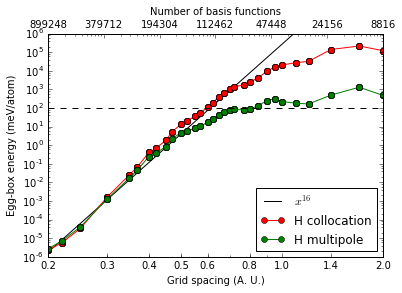

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

ticks = [0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 1.4, 2.0]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlim([0.2,2.0])
ax1.set_ylim([1.0e-6,1.0e6])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticks(ticks)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlabel('Grid spacing (A. U.)')
ax1.set_ylabel('Egg-box energy (meV/atom)')
ax1.plot(hgrids['False'],[ 10.0*Htomev*x**16 for x in hgrids['False']],'k-',label='$x^{16}$')
ax1.plot(hgrids['False'],diff['False'],'ro-',label='H collocation')
ax1.plot(hgrids['True'],diff['True'],'go-',label='H multipole')
ax1.plot(hgrids['False'],100.0*np.ones_like(hgrids['False']),'k--')
ax1.legend(loc=4)

ax2 = ax1.twiny()
ax2.set_ylim([1.0e-6,1.0e6])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.set_xticks(ticks)
ax2.set_xticklabels([degrees[h] for h in ticks])
ax2.set_xlabel('Number of basis functions')

plt.show()

In this figure, we indicate the maximum egg-box error for any rotation in function of the grid spacing. The basis set used, Daubechis wavelets, are invariant by translation for any polynomial functions up to the order 7. Any rotation can be seen as small translations at each point of the grids. This is why we have a behaviour of $x^{16}$ for the egg-box error.